# SPAM errors

## Introduction
State Preparation And Measurement (SPAM) errors were introduced in the introductory tutorial [Simulating sequences with errors and noises](noisy_sim.nblink). They will be further detailed in this notebook. We recommend you to check the introductory tutorial before going through this one.

SPAM errors can be:

- A state preparation error (with probability η for each atom), where an atom is not correctly pumped to the ground state at the beginning, making it effectively unavailable throughout the sequence.
- Measurement errors which are linked to the incorrect identification of the final state of the atoms: during the imaging process, excited rydberg atoms in $\ket{r}$ might decay to the state $\ket{g}$, allowing them to be trapped in the tweezers. This produces false negatives with rate $\epsilon'$. 
- On the contrary, some atoms in the ground state $\ket{g}$ might be kicked out for various reasons (e.g. collisions with residual gas in the chamber) and tweezers recapture might fail, inferring them incorrectly as atoms in the excited state $\ket{r}$ - those are the false positives that happen with rate $\epsilon$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Register, Pulse, Sequence
from pulser_simulation import SimConfig, QutipEmulator
from pulser.devices import AnalogDevice

## Single atom noisy simulations

### Sequence preparation

We prepare a single atom.

In [2]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

We act on this atom with a Constant Pulse, such that it oscillates between the ground state and excited Rydberg state (Rabi oscillations):

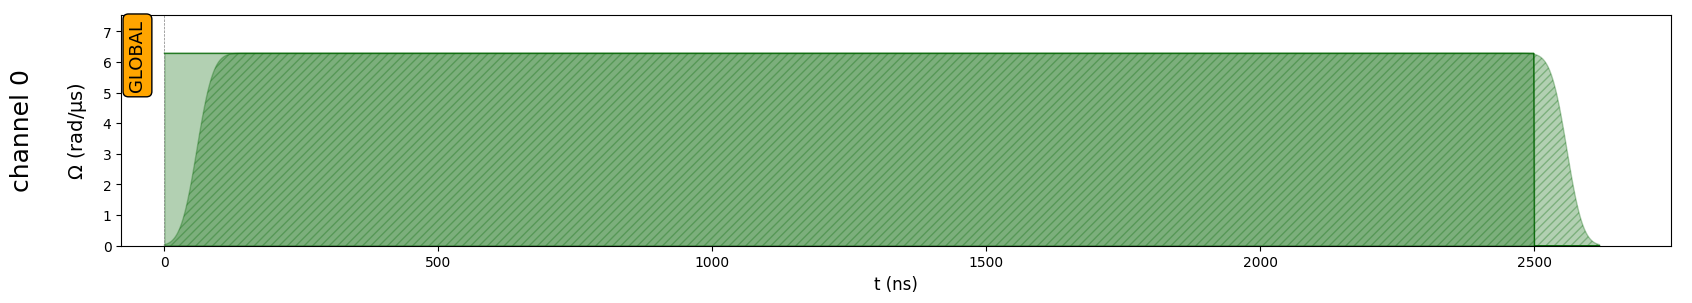

In [3]:
seq = Sequence(reg, AnalogDevice)
seq.declare_channel("channel 0", "rydberg_global")
duration = 2500
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0.0, 0.0)
seq.add(pulse, "channel 0")
seq.draw()

We now create the simulation object and an observable which describes the excited state population.

In [4]:
sim = QutipEmulator.from_sequence(seq, sampling_rate=0.05)
obs = qutip.basis(2, 0).proj()

## SPAM effects

In this part we compare noiseless and noisy simulations for the default SPAM parameters (taken from [De Léséleuc, et al., 2018](https://arxiv.org/abs/1802.10424))

In [5]:
# SPAM configuration
config_spam = SimConfig(noise=("SPAM"), runs=30, samples_per_run=5)

# Integration of the SPAM noise configuration to the simulation
sim.set_config(config_spam)
sim.show_config()

# Simulation storing 40% of the results:
sim.set_evaluation_times(0.4)
res_spam = sim.run()

Options:
----------
Number of runs:        30
Samples per run:       5
Noise types:           SPAM
SPAM dictionary:       {'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}


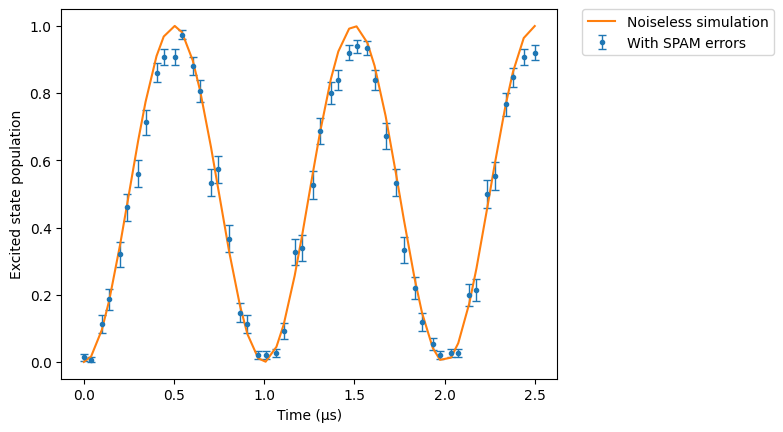

In [6]:
res_spam.plot(obs, label="With SPAM errors")

# Noiseless simulation:
sim.reset_config()
res_clean = sim.run()
res_clean.plot(obs, label="Noiseless simulation")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

Let's modify the *SPAM* dictionary to increase the state preparation error rate ($\eta=40$%).

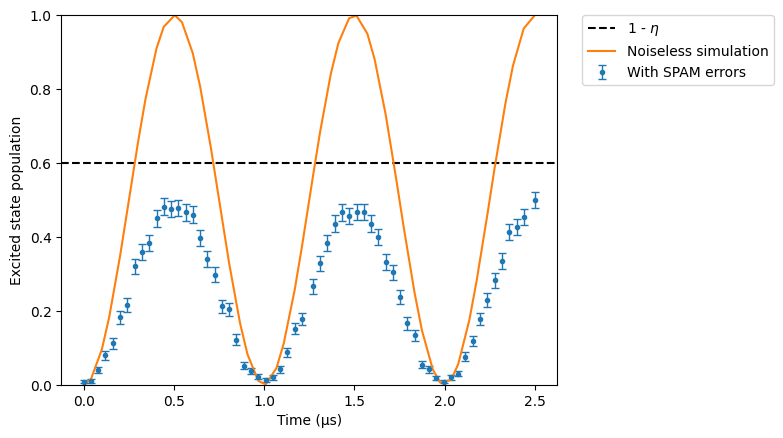

In [7]:
config_spam_mod = SimConfig(noise=("SPAM"), eta=0.4, runs=100)
sim.set_config(config_spam_mod)
sim.set_evaluation_times(0.5)
res_large_eta = sim.run()

plt.figure()
plt.ylim(0, 1)
plt.axhline(
    1 - config_spam_mod.eta, color="black", linestyle="--", label=r"1 - $\eta$"
)
res_large_eta.plot(obs, label="With SPAM errors")
res_clean.plot(obs, label="Noiseless simulation")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

We can observe here that the population doesn't go above $0.6 = 1 - \eta$, which is to be expected: badly prepared atoms are not used at all in the simulations. The more runs we perform, the closer the maximum population will be to $0.6$.

## Changing $\eta$

First, we reset all SPAM errors values to $0$. Then, we do a sweep over the parameter $\eta$ to see how it modifies the simulation results.

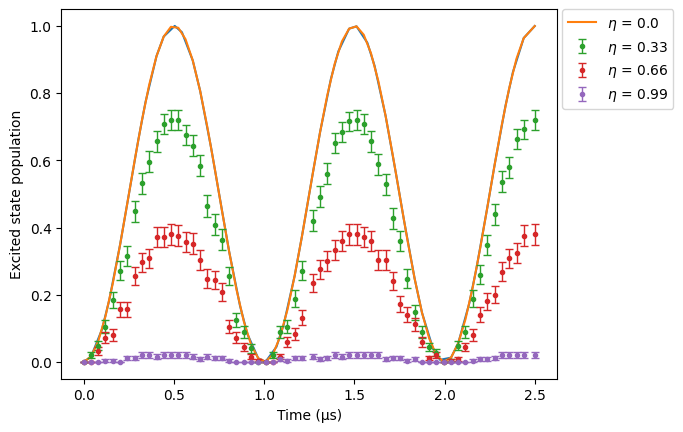

In [8]:
res_clean.plot(obs)
for eta in np.linspace(0, 0.99, 4):
    config_spam_eta = SimConfig(
        noise="SPAM", eta=eta, runs=50, epsilon=0, epsilon_prime=0
    )
    sim.set_config(config_spam_eta)
    sim.run().plot(obs, label=rf"$\eta$ = {eta}")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

As $\eta$ grows, more atoms are badly prepared (i.e, pumped into a state different from $\ket{g}$) and so less atoms are excited into the Rydberg state. You can increase the number of runs to smooth the curves.

### Changing $\epsilon$ and $\epsilon'$

Let's now compare sweeps over $\epsilon$ and $\epsilon'$ side by side:

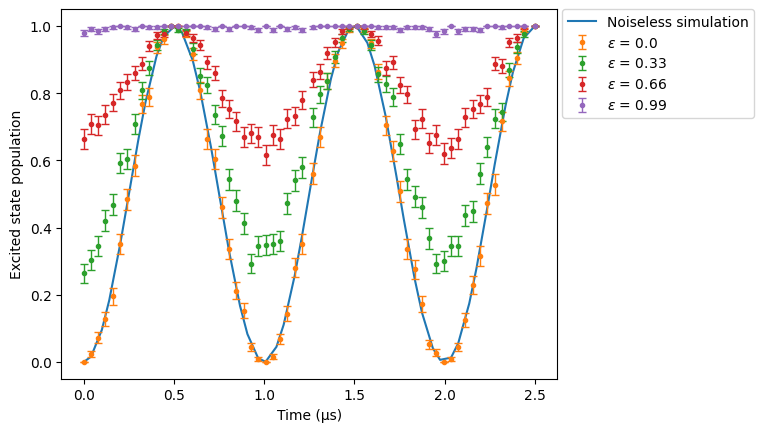

In [9]:
res_clean.plot(obs, label="Noiseless simulation")
for eps in np.linspace(0, 0.99, 4):
    config_spam_eps = SimConfig(
        noise="SPAM", eta=1e-8, runs=50, epsilon=eps, epsilon_prime=0
    )
    sim.set_config(config_spam_eps)
    sim.run().plot(obs, label=rf"$\epsilon$ = {eps}")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

When we increase the proportion of false positives, the percentage of atoms in the excited state increases as expected. Note that when $\eta=0$, the results object we obtain is a `CoherentResults` rather than a `NoisyResults`. This is because state preparation errors require you to sample a probability distribution to obtain the atoms that were badly prepared (thus forcing you to use `NoisyResults`), while measurement errors can be applied coherently to a state vector or density matrix.

Finally, we sweep over the $\epsilon '$ values:

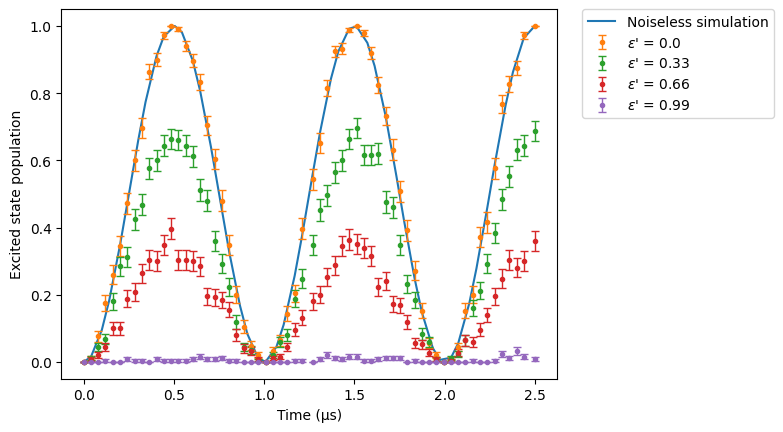

In [10]:
res_clean.plot(obs, label="Noiseless simulation")
for eps_p in np.linspace(0, 0.99, 4):
    config_spam_eps_p = SimConfig(
        noise="SPAM", eta=1e-8, runs=50, epsilon=0, epsilon_prime=eps_p
    )
    sim.set_config(config_spam_eps_p)
    sim.run().plot(obs, label=rf"$\epsilon$' = {eps_p}")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

In contrast to the previous case, when the number of false negatives increases, the system behaves as if all atoms are in the ground state leading to zero population in the excited state.